In [1]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.util import crop
from skimage.io import imsave, imread
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
from skimage.morphology import disk
from skimage.io import imsave
import time


sys.path.append('../src')
import unet7

In [2]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_cols = 1392
img_rows = 1040
epochs = 1 #100 1001
batch_size = 80
smooth = 1.
start_lr = 1e-4
target_width = 256
target_height = 192

upscale_factor_width = img_cols / target_width
upscale_factor_height = img_rows / target_height

In [3]:
def checkDir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def read_imgs(dir, img_rows, img_cols):
    images = [f for f in os.listdir(dir) if f.endswith('.tif')]
    imgs = np.ndarray((len(images), img_rows, img_cols, 1), dtype=np.float)
    for idx, img in enumerate(images):
        #print(idx)
        img = imread(os.path.join(dir, img), as_gray=True)
        img = np.expand_dims(img, axis=-1)
        imgs[idx] = img
    return imgs

def test_model(model, x, y_true, log_dir):
    y_true = np.rint(y_true[0])
    y_pred = model.predict(x)
    y_pred = np.rint(y_pred[0])
    x = x[0]

    plt.figure(figsize=(40,8))
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.imshow(np.squeeze(x))

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(np.squeeze(y_pred))

    plt.subplot(1, 3, 3)
    plt.title('Ground truth')
    plt.imshow(np.squeeze(y_true))

    plt.savefig(os.path.join(log_dir,'ground_truth_e{}.pdf'.format('test')), bbox_inches='tight', dpi=300)
    plt.show()

def read_imgs_masks(img_dir, mask_dir, img_rows, img_cols,
                    target_width=target_width, target_height=target_height):
    images = [f for f in os.listdir(img_dir) if f.endswith('.tif')]
    imgs = np.ndarray((len(images), target_height, target_width, 1), dtype=np.float)
    masks = np.ndarray((len(images), target_height, target_width, 1), dtype=np.float)
    for idx, img in enumerate(images):
        #print(idx)
        msk = img.replace('.tif', '_Simple Segmentation.tif')
        img = imread(os.path.join(img_dir, img), as_gray=True)
        img = resize(img, (target_height, target_width))
        img = np.expand_dims(img, axis=-1)
        imgs[idx] = img
        
        mask = imread(os.path.join(mask_dir, msk), as_gray=True)
        mask = resize(mask, (target_height, target_width))
        mask = np.expand_dims(mask, axis=-1)
        masks[idx] = mask
    return imgs, masks



In [4]:
runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = os.path.join('..','data')
log_dir = os.path.join(model_dir, 'Practice','logs',"{}".format(runningTime))
checkDir(log_dir)

In [5]:
# Training


tensorboard = TensorBoard(log_dir=os.path.join(model_dir,"{}".format(runningTime)))
callbacksList = [tensorboard]

#model = unet7.get_unet(img_cols, img_rows)
model = unet7.Unet(target_width, target_width, nclasses=1)

#model.compile(optimizer=Adam(lr=5e-5), loss=unet7.dice_coef_loss, metrics=[unet7.dice_coef])
model.compile(optimizer=Adam(learning_rate=start_lr), loss=unet7.dice_loss, metrics=[unet7.dice_coeff])

model.summary()
print("start tensorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir,"{}".format(runningTime)+"\""))

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 8)  0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [6]:
data = np.load('../data/small_res_dataset_sample.npz')
training_imgs=data['training_imgs']
training_masks=data['training_masks']
test_imgs=data['test_imgs']
test_masks=data['test_masks']
del data

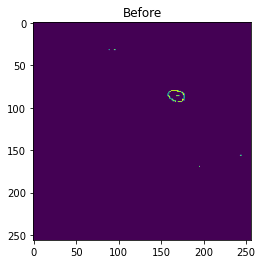

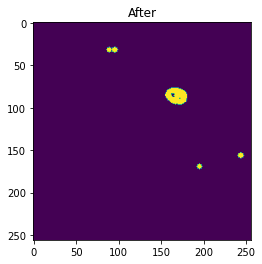

In [7]:
# improve the masks
test = training_masks[0]
plt.figure()
plt.title('Before')
plt.imshow(np.squeeze(test))

footprint = disk(3)
test = dilation(np.squeeze(test), footprint)


plt.figure()
plt.title('After')
plt.imshow(np.squeeze(test))

In [8]:
for i in range(training_masks.shape[0]):
    training_masks[i,:,:,0] = dilation(np.squeeze(training_masks[i,:,:,0]), footprint)

for i in range(test_masks.shape[0]):
    test_masks[i,:,:,0] = dilation(np.squeeze(test_masks[i,:,:,0]), footprint)

In [9]:
# Data augmentation

img_gen_args = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     #rotation_range=30,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     vertical_flip=True,
                     horizontal_flip=True,
                     #zoom_range=[0.8,1.2],
                     #brightness_range=[0.8,1.2],
                     fill_mode='nearest')

mask_gen_args = dict(samplewise_center=False,
                     samplewise_std_normalization=False,
                     #rotation_range=15,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     vertical_flip=True,
                     horizontal_flip=True,
                     preprocessing_function=np.rint,
                     #zoom_range=[0.8,1.2],
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**img_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

seed = 123
image_datagen.fit(training_imgs, augment=True, seed=seed)
mask_datagen.fit(training_masks, augment=True, seed=seed)

image_generator = image_datagen.flow(training_imgs, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(training_masks, batch_size=batch_size, seed=seed)

gen_train = zip(image_generator, mask_generator)


img_gen_args_test = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     #rotation_range=30,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     #vertical_flip=True,
                     #horizontal_flip=True,
                     #zoom_range=[0.8,1.2],
                     #brightness_range=[0.8,1.2],
                     fill_mode='nearest')

mask_gen_args_test = dict(samplewise_center=False,
                     samplewise_std_normalization=False,
                     #rotation_range=15,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     #vertical_flip=True,
                     #horizontal_flip=True,
                     preprocessing_function=np.rint,
                     #zoom_range=[0.8,1.2],
                     fill_mode='nearest')

image_datagen_test = ImageDataGenerator(**img_gen_args_test)
mask_datagen_test = ImageDataGenerator(**mask_gen_args_test)

seed = 123
image_datagen_test.fit(test_imgs, augment=True, seed=seed)
mask_datagen_test.fit(test_masks, augment=True, seed=seed)

image_generator_test = image_datagen_test.flow(test_imgs, batch_size=batch_size, seed=seed)
mask_generator_test = mask_datagen_test.flow(test_masks, batch_size=batch_size, seed=seed)

gen_test = zip(image_generator_test, mask_generator_test)

7/7 [==============================] - 8s 820ms/step - loss: 0.9747 - dice_coeff: 0.0253 - val_loss: 0.9690 - val_dice_coeff: 0.0310


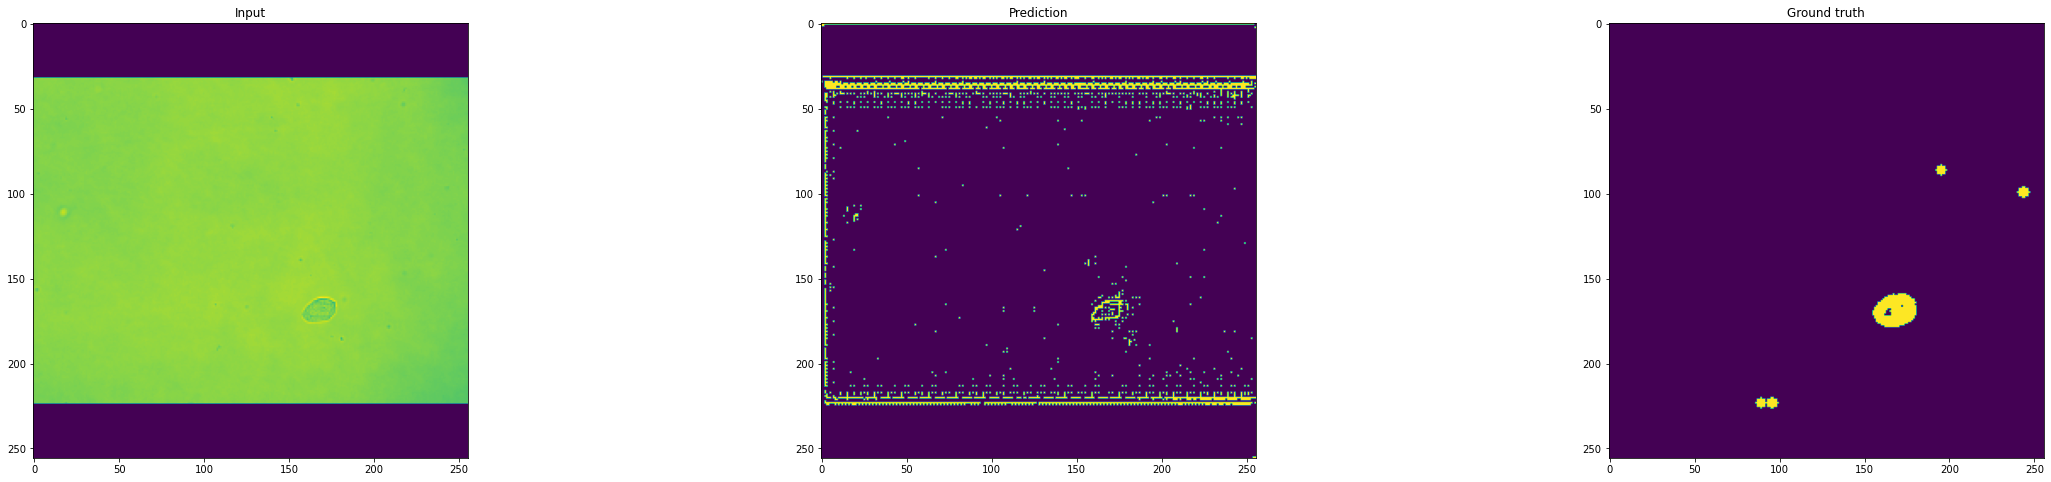

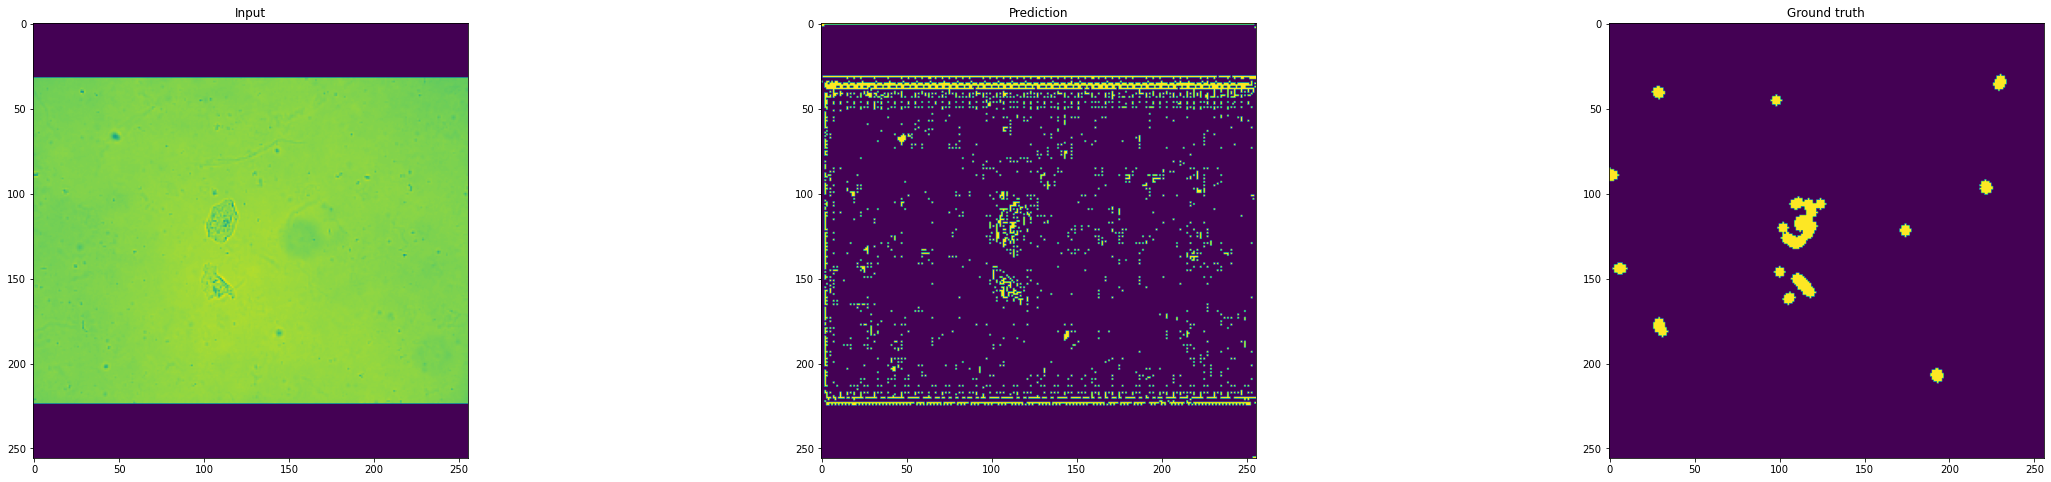

In [10]:
model.fit(
        gen_train,
        batch_size = batch_size,
        steps_per_epoch=training_imgs.shape[0] // epochs, #200, 40
        epochs=epochs,
        validation_freq = 1,
        validation_data=gen_test, validation_steps=1,
        callbacks=callbacksList)

img_exmp = image_generator.next()
mask_exmp = mask_generator.next()
test_model(model, img_exmp, mask_exmp, log_dir)

test_img_exmp = image_generator_test.next()
test_mask_exmp = mask_generator_test.next()
test_model(model, test_img_exmp, test_mask_exmp, log_dir)